In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil


CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cats-in-the-wild-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2949345%2F5079563%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240418%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240418T164223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7681de62eab20d6daff9a74218660a416801a02edf213b71b27fe6e6392efb90494c03a13eb27b67bf5eb1f1deb059d51db603424dd63d2e57ea4a2e90a4243db6524a90ad2b6d641c5ae1854b05bc0f0bc7f0e6f2c9113547cceb361b299b5aa288807da262aad6228c689c422aea9a687779943465daff3136506386928452524adaa6095c1c3294569f13a11c4809d922972297fbfb7464ce67b21b4c3ccb83971f7d8ccec0500d21e3eb1d7a1b09f66bb47deca5c420a1cfdb539acc493503910e4df8ff3e0b1d538d5b148d3b80ef2997967c69bac48d110e1f2960bbaeff42b0404c4444de267dbcdd0a74c8f5234373122e94f2dc7077309513bc7d1e,tigerdd:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4825712%2F8157487%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240418%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240418T164223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4e46f7b8ee7de610383d032d4695b85f65d2f99897be86c4f3396614eec47def0596b4408512311928e9b2189e6a20129d32c5aac95fd9bc98b4296977e616c86bbc9cf5e45a2cdc54379ebee299cdf4e22c17836ab176c7cce35f8ef51f55812effde6dd2ad589e1d566f314fdd54ab72b612c85d1ab50e8033470dda2ed3b2e123fc22b993a7d86c1af38531be0f243d62ee7cb8586b7227040de6b54b6bf4a5a83932ac37fffbc8591ab795f38d799306dfcb30ee180e9feb0dc87233bd32da672b2f29882f7b928ae3582e8ddecf93c15545599e78da9726dbcb3105a1e19f3b5919c87dd6b19e644da35b0eb242f5ee4136da48d85af6aae770d4ee0354'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 129247887 bytes downloaded
Downloaded and uncompressed: cats-in-the-wild-image-classification
[==================================================] 290959 bytes downloaded
Downloaded and uncompressed: tigerdd
Data source import complete.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pathlib import Path

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Activation, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Model Architecture
from tensorflow.keras.applications import ResNet50V2


In [ ]:
# directories and paths
test_path = Path("/kaggle/input/cats-in-the-wild-image-classification/test")
train_path = Path("/kaggle/input/cats-in-the-wild-image-classification/train")

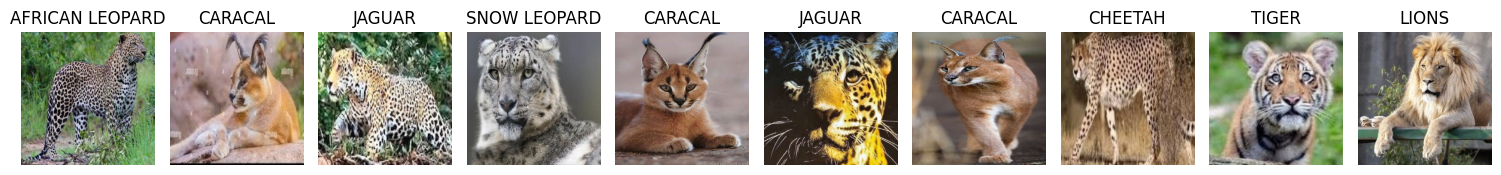

In [ ]:
# Display some of the images
image_files_with_labels = [(str(image_path), image_path.parent.name) for image_path in train_path.glob("**/*.jpg")]
num_images_to_display = 10
selected_images = random.sample(image_files_with_labels, num_images_to_display)
plt.figure(figsize=(15, 15))
for i, (image_path, label) in enumerate(selected_images):
    plt.subplot(3, num_images_to_display, i + 1)
    plt.imshow(plt.imread(image_path))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Divide data in two parts 1 data directory 2 label (parent.name)
train_set = [(str(image_path), image_path.parent.name) for image_path in train_path.glob("**/*.jpg")]
test_set = [(str(image_path), image_path.parent.name) for image_path in test_path.glob("**/*.jpg")]

train, label_train = zip(*train_set)
test, label_test = zip(*test_set)

# Function that format and convert img
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Load and resize image
    img_array = img_to_array(img)  # Convert image to array
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

x_train_samp = np.array([preprocess_image(x) for x in train])
x_test_samp = np.array([preprocess_image(x) for x in test])

x_train_samp.shape, x_test_samp.shape # check shapes

((2339, 224, 224, 3), (50, 224, 224, 3))

In [ ]:
# Encode and prepare data
encoder = OrdinalEncoder() # Use ordinal encoder since we have binary classification
label_train = np.array(label_train).reshape(-1, 1) # label_train is tuple make it numpy for training
y_train_samp = encoder.fit_transform(label_train)
y_train_samp.shape

(2339, 1)

In [ ]:
# The same applies with test set
label_test = np.array(label_test).reshape(-1, 1)
y_test_samp = encoder.fit_transform(label_test)
y_test_samp.shape

(50, 1)

In [ ]:
# Set seeds for reproducibility
tf.random.set_seed(45)
np.random.seed(45)

# Define augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define your model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(512, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4), loss=loss_fn, metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)



In [ ]:
# Train the model
history = model.fit(
    datagen.flow(x_train_samp, y_train_samp, batch_size=32),
    steps_per_epoch=int(len(x_train_samp) / 32),
    epochs=5,
    validation_data=(x_test_samp, y_test_samp),
    callbacks=[early_stopping, learning_rate_reduce]

)

In [ ]:
# Collect all TL models
resnet = ResNet50V2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in resnet.layers:
    layer.trainable = False

In [ ]:
    # Create the simplest model architecture using the current backbone.
model = keras.Sequential([
        resnet,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    # Compile the model with the specified loss function, optimizer, and metrics.
model.compile(
        loss='categorical_crossentropy',
        optimizer= "adam",
        metrics=['accuracy']
    )

batch_size=64
y_train_samp_onehot = tf.keras.utils.to_categorical(y_train_samp, num_classes=10)
y_test_samp_onehot = tf.keras.utils.to_categorical(y_test_samp, num_classes=10)
history = model.fit(
        x_train_samp, y_train_samp_onehot,
        epochs=10,
        validation_data=(x_test_samp, y_test_samp_onehot),
        batch_size=batch_size
    )

Epoch 1/10
37/37 [==============================] - 12s 197ms/step - loss: 1.3543 - accuracy: 0.5498 - val_loss: 0.2853 - val_accuracy: 1.0000
Epoch 2/10
37/37 [==============================] - 6s 167ms/step - loss: 0.4451 - accuracy: 0.8598 - val_loss: 0.1441 - val_accuracy: 1.0000
Epoch 3/10
37/37 [==============================] - 6s 166ms/step - loss: 0.3193 - accuracy: 0.9029 - val_loss: 0.1140 - val_accuracy: 1.0000
Epoch 4/10
37/37 [==============================] - 6s 171ms/step - loss: 0.2622 - accuracy: 0.9201 - val_loss: 0.0889 - val_accuracy: 1.0000
Epoch 5/10
37/37 [==============================] - 6s 169ms/step - loss: 0.2244 - accuracy: 0.9354 - val_loss: 0.0821 - val_accuracy: 1.0000
Epoch 6/10
37/37 [==============================] - 6s 167ms/step - loss: 0.2090 - accuracy: 0.9354 - val_loss: 0.0658 - val_accuracy: 1.0000
Epoch 7/10
37/37 [==============================] - 6s 170ms/step - loss: 0.1912 - accuracy: 0.9444 - val_loss: 0.0636 - val_accuracy: 1.0000
Epoch

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


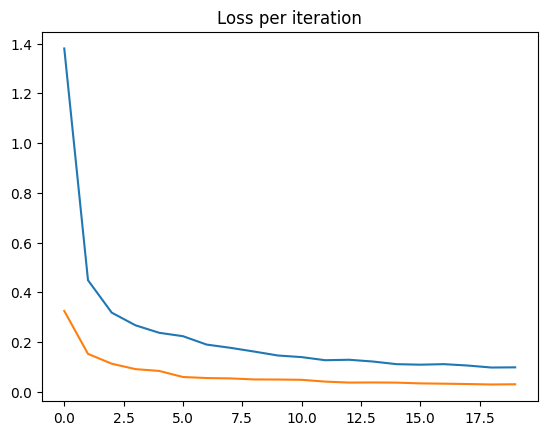

In [ ]:
# Loss per iteration
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss per iteration')
plt.show()

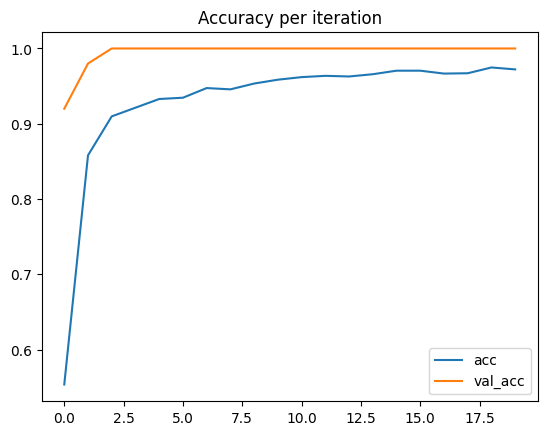

In [ ]:
# Accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy per iteration')
plt.legend()
plt.show()

In [ ]:
yhat = model.predict(x_test_samp) # Predict
y_pred = (yhat > 0.5).astype(int) # threhold

2/2 [==============================] - 5s 2s/step


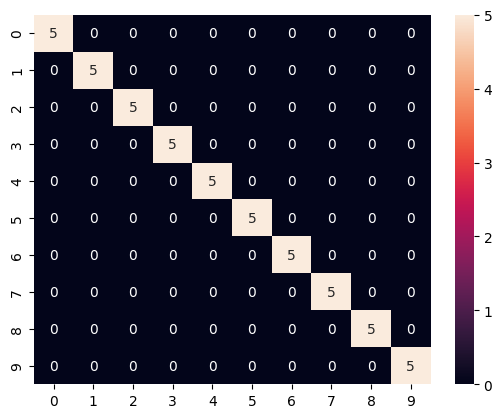

In [ ]:

# Convert one-hot encoded labels back to original labels
y_test_samp_labels = np.argmax(y_test_samp_onehot, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Draw Confusion Matrix
sns.heatmap(confusion_matrix(y_test_samp_labels, y_pred_labels), annot=True, fmt='g')
plt.show()

In [ ]:
# Convert one-hot encoded labels back to original labels
y_test_samp_labels = np.argmax(y_test_samp_onehot, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test_samp_labels, y_pred_labels))

# Compute and print accuracy score
accuracy = accuracy_score(y_test_samp_labels, y_pred_labels)
print("Model accuracy: ", accuracy)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Model accuracy:  1.0


In [ ]:
tf.keras.models.save_model(model, 'model_yh.keras')

In [ ]:
load = tf.keras.models.load_model('model_yh.keras')

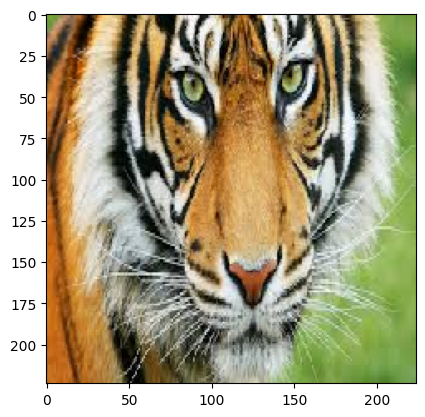

In [ ]:
img_path = '/content/download.jpeg'
img = preprocess_image(img_path)
plt.imshow(img)

In [ ]:
 # Make predictions using the model
img_array = np.expand_dims(img, axis=0)
pred_probs = load.predict(img_array)[0]

# Get the predicted class and its probability
pred_id = np.argmax(pred_probs)
prob = pred_probs[pred_id]


print(f"Probability: {prob * 100:.1f}%")
print(pred_id)

1/1 [==============================] - 0s 87ms/step
Probability: 99.7%
9
